In [21]:
import pandas as pd
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from Bio import SeqIO
import tarfile
import gzip
%load_ext autoreload
%autoreload 2
from helpers_barplot_intersection import plot_text, plot_intersection_bars
from helpers_barplot_intersection_kmers import explode_immunopepper_coord, search_result_peptides_ids 
from helpers_barplot_intersection_kmers import get_pep_ids, get_pep_coord, tar_reader
from helpers_barplot_intersection_kmers import validated_filtered_kmers, reader_assign_conf_pep
from helpers_barplot_intersection_kmers import compare_OHSU_ETH, kmer_in_bi_exon_peptide


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# INPUTS 
read_from_disk = True # or reload
proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024'
#proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics'

pipelines = ['OHSU', 'ETH']

FDR_limit = 0.05
MS_FDR = '_crema' #choices: '_crema' '_crux' or ''
MS_strategy = 'joint' #Choices: 'pool' 'joint', 'single' 

#pool: pool all experiments per pipeline
#joint: pool all experiments for both pipeline
#single: per experiment per pipeline

if MS_FDR == '_crema':
    FDR_file = 'crema.peptides.txt'
    col_seq = 'sequence'
    col_qvalue = 'crema q-value'
elif MS_FDR == '_crux' or  MS_FDR == '':
    FDR_file = 'assign-confidence.target.txt'
    col_seq = 'unmodified sequence'
    col_qvalue = 'tdc q-value'
else:
    print(f'ERROR: wrong input for {FDR_file}')

    

sample_plot_dir = {}
run_type_plot_dir = {}    
all_samples = []

# BRCA
samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                  'TCGA-AO-A0JM-01A-21R-A056-07',
                  'TCGA-BH-A18V-01A-11R-A12D-07',
                  'TCGA-A2-A0D2-01A-21R-A034-07',
                  'TCGA-A2-A0SX-01A-12R-A084-07']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
# OV
samples = ['TCGA-25-1319-01A-01R-1565-13',
                  'TCGA-25-1313-01A-01R-1565-13',
                  'TCGA-61-2008-01A-02R-1568-13',
                  'TCGA-24-1431-01A-01R-1566-13',
                  'TCGA-24-2298-01A-01R-1569-13']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'OV'
    
fasta_base_OHSU = '/cluster/work/grlab/projects/projects2020_OHSU/share_OHUS_PNLL/current'
fasta_base_ETH = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/*/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar'
        #format fasta_file = f'{fasta_base_OHSU}/J_{sample}_pool_kmer.fa'
        #format fasta_file = f'{fasta_base_ETH}/G_{sample}_pool_kmer_25012024.fa.gz'
kmer_files_OHSU = '/cluster/work/grlab/projects/projects2020_OHSU/share_OHUS_PNLL/current/kmer_files'
save_folder = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots'
# PLOTTING Parameters 
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15
save = False
sample = None

# Parse: results for all experiments

In [23]:
## Get kmers from result files
if read_from_disk:
    samples_store_kmers = {}
    samples_store_rates_kmers = {}

    for sample in all_samples:

        sample_short = '-'.join(sample.split('-')[0:3])
        samples_store_kmers[sample] = defaultdict(dict)
        samples_store_rates_kmers[sample] = defaultdict(dict)
        for pipeline in pipelines:
            path_single = os.path.join(proteomicsdir, pipeline, sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')
            path_pool_pipeline = os.path.join(proteomicsdir, pipeline, sample_short, 
                                              f'assign_conf_pooled_FDR{MS_FDR}')
            path_pool_union = os.path.join(proteomicsdir, 
                                           f'assign_conf_joint_to_{pipeline}{MS_FDR}', sample_short)
            path_TEST_OHSU = os.path.join(proteomicsdir, 'OHSU', sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')
            path_TEST_ETH = os.path.join(proteomicsdir, 'ETH', sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')


            experiment_list = [ i.split('/')[-1] for i in glob.glob(path_single + '/*')] #check

            for experiment in experiment_list:
                if pipeline == 'OHSU':
                    original_name = experiment
                    cut_name = experiment[1:]
                else:
                    original_name = experiment
                    cut_name = experiment          

                if os.path.isfile(os.path.join(path_TEST_OHSU, 'J' + cut_name, FDR_file)) and \
                     os.path.isfile(os.path.join(path_TEST_ETH, cut_name, FDR_file)): #Commun experiments               

                    # search 1 experiment, 1 pipeline  
                    if MS_strategy == 'single':
                        df = os.path.join(path_single, original_name, FDR_file)
                    # search all experiments, 1 pipeline
                    if MS_strategy == 'pool':
                        df = os.path.join(path_pool_pipeline, f'tsearch-{original_name}.txt')
                    # search all experiments, 1 union of pipelines
                    if MS_strategy == 'joint':
                        df = os.path.join(path_pool_union, f'tsearch-{original_name}.txt')

                    df_filtered = reader_assign_conf_pep(df, FDR_limit, col_seq, col_qvalue)
                    
                    df_filtered, val_rate_kmers = validated_filtered_kmers(df_filtered, fasta_base_OHSU, kmer_files_OHSU,
                                                           fasta_base_ETH, sample, experiment, 
                                                           pipeline, col_seq)

                        
                    samples_store_kmers[sample][cut_name][pipeline] = set(df_filtered['kmer'])
                    samples_store_rates_kmers[sample][cut_name][pipeline] = val_rate_kmers
                        
                    print(f'{len( samples_store_kmers[sample][cut_name][pipeline])} validated kmers')

                    print('\n')


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-C8-A12P/tsearch-J0A53XGA.txt
With Shape: 18
With unique peptides: 18
Number of validated psm: (0, 7)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-C8-A12P/tsearch-J0A13AGA.txt
With Shape: 134
With unique peptides: 134
Number of validated psm: (4, 7)
26 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-C8-A12P/tsearch-J0A51XGA.txt
With Shape: 6
With unique peptides: 6
Number of validated psm: (0, 7)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-C8-A12P/tsearch-J0213XGA.txt
With Shape: 19
With unique peptides: 19
Number of validated psm: (1, 7)
8 validated kmers


Reading /cluster/work/grlab/pro

15 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-AO-A0JM/tsearch-J0213XGA.txt
With Shape: 10
With unique peptides: 10
Number of validated psm: (0, 7)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-AO-A0JM/tsearch-J0AN01GA.txt
With Shape: 221
With unique peptides: 221
Number of validated psm: (5, 7)
37 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-AO-A0JM/tsearch-J0A532GA.txt
With Shape: 3
With unique peptides: 3
Number of validated psm: (0, 7)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-AO-A0JM/tsearch-J0A11XGA.txt
With Shape: 12
With unique peptides: 12
Number of validated psm: (1, 7)
7 validated kmers


Reading /c

With Shape: 142
With unique peptides: 142
Number of validated psm: (9, 7)
51 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-BH-A18V/tsearch-J0A51XGA.txt
With Shape: 6
With unique peptides: 6
Number of validated psm: (0, 7)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-BH-A18V/tsearch-J0213XGA.txt
With Shape: 18
With unique peptides: 18
Number of validated psm: (0, 7)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-BH-A18V/tsearch-J0AN01GA.txt
With Shape: 215
With unique peptides: 215
Number of validated psm: (8, 7)
43 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-BH-A18V/tsearch-J0A532GA.txt
With Shape: 10
With unique p

0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crema/TCGA-BH-A18V/tsearch-02101GA.txt
With Shape: 2
With unique peptides: 2
Number of validated psm: (0, 9)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crema/TCGA-BH-A18V/tsearch-0A11XGA.txt
With Shape: 3
With unique peptides: 3
Number of validated psm: (0, 9)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crema/TCGA-BH-A18V/tsearch-02132GA.txt
With Shape: 7
With unique peptides: 7
Number of validated psm: (0, 9)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crema/TCGA-BH-A18V/tsearch-0253AGA.txt
With Shape: 2
With unique peptides: 2
Number of validated psm: (0, 9)
0 validated kmers


Reading /cluster/work/grlab/

22 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-A2-A0D2/tsearch-J0253AGA.txt
With Shape: 3
With unique peptides: 3
Number of validated psm: (0, 7)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-A2-A0D2/tsearch-J0A132GA.txt
With Shape: 36
With unique peptides: 36
Number of validated psm: (1, 7)
7 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-A2-A0D2/tsearch-J0A53AGA.txt
With Shape: 26
With unique peptides: 26
Number of validated psm: (1, 7)
8 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-A2-A0D2/tsearch-J02101GA.txt
With Shape: 3
With unique peptides: 3
Number of validated psm: (0, 7)
0 validated kmers


Reading /cluste

12 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-A2-A0SX/tsearch-J0A51XGA.txt
With Shape: 3
With unique peptides: 3
Number of validated psm: (0, 7)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-A2-A0SX/tsearch-J0213XGA.txt
With Shape: 20
With unique peptides: 20
Number of validated psm: (0, 7)
0 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-A2-A0SX/tsearch-J0AN01GA.txt
With Shape: 193
With unique peptides: 193
Number of validated psm: (4, 7)
29 validated kmers


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crema/TCGA-A2-A0SX/tsearch-J0A532GA.txt
With Shape: 5
With unique peptides: 5
Number of validated psm: (0, 7)
0 validated kmers


Reading /clu

AssertionError: 

In [ ]:
%debug

> /cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection_kmers.py(191)validated_filtered_kmers()
    189         if df_filtered_jx.shape[0] !=len(test):
    190 
--> 191             assert(df_filtered_jx.shape[0] == len(test))
    192 
    193         # Add the kmers to the filtered DF

ipdb> len(df_filtered_jx.shape[0])
*** TypeError: object of type 'int' has no len()
ipdb> df_filtered_jx.shape[0]
446
ipdb> len(test)
349
ipdb> issues
[9, 15, 22, 26, 29, 30, 46, 48, 52, 54, 57, 58, 59, 63, 67, 74, 87, 90, 91, 96, 97, 104, 109, 115, 118, 123, 126, 128, 132, 138, 139, 148, 152, 162, 167, 172, 179, 185, 189, 213, 215, 224, 228, 232, 235, 237, 239, 243, 244, 247, 257, 263, 269, 272, 274, 278, 279, 286, 289, 293, 296, 299, 307, 308, 313, 320, 322, 329, 334, 338, 339, 342, 345, 347, 348, 351, 360, 361, 364, 365, 374, 376, 387, 389, 393, 396, 401, 405, 411, 414, 416, 421, 423, 431, 438, 442, 444]
ipdb> df_filtered_jx.iloc[9

In [4]:
# Performs sets comparisons
compare = compare_OHSU_ETH(samples_store_kmers, read_from_disk)

NameError: name 'samples_store_kmers' is not defined

# Plot: Results per experiment

In [5]:
# Choose plotting sample
sample = 'TCGA-25-1319-01A-01R-1565-13'
#sample =  'TCGA-AO-A0JM-01A-21R-A056-07'

In [6]:
if read_from_disk:
    df = pd.DataFrame(compare)
    display(df.head())
    print(df.shape)
else:
    df = None

In [7]:
def run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save):
    order_file = os.path.join(sample_plot_dir[sample], f'{sample}_Barplot_sorting.tsv.gz')
    order_file = pd.read_csv(order_file, sep = '\t')
    display(order_file.head())
    print(order_file.shape)
    df_plot = order_file.merge(df, on = ['sample', 'filter_'], how = 'inner')
    df_plot = df_plot.fillna(0)
    print(df_plot.shape)
    df_plot = df_plot.sort_values('index')
    display(df_plot.head())
    # Plotting
    run_type = run_type_plot_dir[sample]

    back_ticks = df_plot['filter_background'] 
    front_ticks = df_plot['filter_foreground']

    serie_index = df_plot['index']
    serie_intersection = df_plot['pep_size_intersection']
    serie_eth = df_plot['pep_size_eth']
    print(serie_eth)
    serie_ohsu = df_plot['pep_size_ohsu']
    y_label = 'Number of MS-detected tryptic junction-peptides'

    name_plot = f'Barplot_ovelap_valKMERS{MS_FDR}_{MS_strategy}'
    base_plot = sample
    plot_dir = sample_plot_dir[sample]

    plot_intersection_bars(back_ticks, front_ticks, ticks_fontsize, axislabels_fontsize, 
                              legend_fontsize, axes_fontsize, run_type, 
                               serie_index, serie_intersection, serie_eth, serie_ohsu,
                               y_label, save, plot_dir, base_plot, name_plot)
    return df_plot

In [10]:
df.head()

,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu


,Unnamed: 0,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu,filter_foreground_target,filter_foreground_reads,filter_foreground_samples,filter_background_reads,filter_background_samples,cohort,motif,index,filter_background,filter_foreground
0,7,TCGA-25-1319-01A-01R-1565-13,02501GA,23972,20052,8874,15098,11178,0,2,5,0,1,G,A,0,"(0, 1)","(0, 2, 5)"
1,30,TCGA-25-1319-01A-01R-1565-13,02512GA,24766,20638,9166,15600,11472,0,2,5,1,2,G,A,1,"(1, 2)","(0, 2, 5)"
2,14,TCGA-25-1319-01A-01R-1565-13,0251AGA,24913,20683,9193,15720,11490,0,2,5,1,A,G,A,2,"(1, A)","(0, 2, 5)"
3,8,TCGA-25-1319-01A-01R-1565-13,0251XGA,24913,20683,9193,15720,11490,0,2,5,1,X,G,A,3,"(1, X)","(0, 2, 5)"
4,15,TCGA-25-1319-01A-01R-1565-13,02532GA,29573,24940,11086,18487,13854,0,2,5,3,2,G,A,4,"(3, 2)","(0, 2, 5)"


(35, 18)
(0, 23)


,Unnamed: 0,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu,filter_foreground_target,filter_foreground_reads,...,cohort,motif,index,filter_background,filter_foreground,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu


Series([], Name: pep_size_eth, dtype: object)


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:98: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)


ValueError: max() arg is an empty sequence

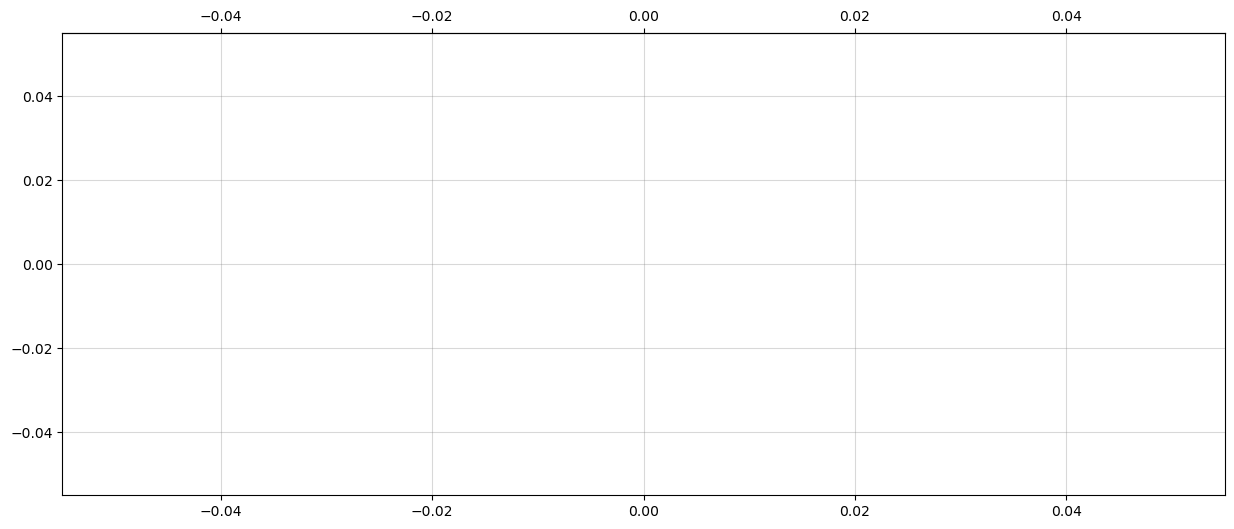

In [8]:
# TMP CODE single sample
path_data = os.path.join(save_folder, f'data_kmers{MS_FDR}_{MS_strategy}.tsv.gz')
if df is not None:
    df.to_csv(path_data, sep = '\t', index = None)
    print(f'Saved data to {path_data}')
else:
    df = pd.read_csv(path_data, sep = '\t')
df_plot = run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save)

In [ ]:
# for sample in all_samples:
#     path_data = os.path.join(sample_plot_dir[sample], f'data{MS_FDR}_{MS_strategy}.tsv.gz')
#     print(path_data)
#     if df is not None:
#         df.to_csv(path_data, sep = '\t', index = None)
#     else:
#         df = pd.read_csv(path_data, sep = '\t')
#     run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save)